In [18]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ───────── Data prep ─────────────────────────────────────────────────────
def prepare_data(path, lag_feats, lags=(1,2,3), val_ratio=0.1):
    df = pd.read_csv(path, parse_dates=["date"])
    df["energy_index"] = df[" Price Index for Consumer: Energy(electricity, heat, fuel) "]
    for L in (1, 7, 14):
        df[f"energy_index_lag{L}"] = df["energy_index"].shift(L)
    for L in lags:
        for feat in lag_feats:
            df[f"{feat}_lag{L}"] = df[feat].shift(L)
    df["label_lag1"] = df["label"].shift(1)

    # event dummies
    policy_dates = [
        pd.Timestamp("2023-04-30"),  # old surrender deadline
        pd.Timestamp("2024-06-30"),  # new free‐allocation date starts
        pd.Timestamp("2024-09-30"),  # first new surrender deadline
    ]
    df["is_policy_day"] = df["date"].isin(policy_dates).astype(int)

    df = df.dropna().sort_values("date").reset_index(drop=True)

    # train/val/test chronological split
    n    = len(df)
    i80  = int(n * 0.8)
    df_tv, df_test = df.iloc[:i80], df.iloc[i80:].reset_index(drop=True)
    nv   = len(df_tv)
    i_val = int(nv * (1 - val_ratio))
    df_train = df_tv.iloc[:i_val].reset_index(drop=True)
    df_val   = df_tv.iloc[i_val:].reset_index(drop=True)

    feats = [c for c in df.columns if c not in ("date","label")]

    # scale
    sX = StandardScaler().fit(df_train[feats])
    sy = StandardScaler().fit(df_train[["label"]])
    for d in (df_train, df_val, df_test):
        d[feats]   = sX.transform(d[feats])
        d["label"] = sy.transform(d[["label"]])

    return df_train, df_val, df_test, feats, sy

class TSData(Dataset):
    def __init__(self, df, feats, seq_len):
        self.X       = df[feats].values.astype(np.float32)
        self.y       = df["label"].values.astype(np.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, i):
        return self.X[i:i+self.seq_len], self.y[i+self.seq_len]


class ResidualAttentionLSTM(nn.Module):
    def __init__(self, feats, hidden_size=32, n_layers=1, dropout=0.3):
        super().__init__()
        self.lag1_idx   = feats.index("label_lag1")
        n_features      = len(feats)
        self.lstm       = nn.LSTM(n_features, hidden_size, n_layers,
                                  batch_first=True,
                                  dropout=dropout if n_layers>1 else 0.0)
        self.key_proj   = nn.Linear(hidden_size, hidden_size)
        self.query_proj = nn.Linear(hidden_size, hidden_size)
        self.fc_delta   = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, 1),
        )

    def forward(self, x):
        lag1 = x[:, -1, self.lag1_idx]
        h, _ = self.lstm(x)
        q      = self.query_proj(h[:, -1, :]).unsqueeze(2)
        K      = self.key_proj(h)
        scores = torch.bmm(K, q).squeeze(2)
        α      = torch.softmax(scores, dim=1).unsqueeze(1)
        context= torch.bmm(α, h).squeeze(1)
        delta  = self.fc_delta(context).squeeze(1)
        return lag1 + delta


def train_validate(model, train_dl, val_dl, device, epochs=30):
    model.to(device)
    opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    crit = nn.MSELoss()
    best_val, wait = float("inf"), 0

    for ep in range(1, epochs+1):

        model.train()
        tr_loss = 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = crit(out, yb)
            loss.backward()
            opt.step()
            tr_loss += loss.item()*xb.size(0)
        tr_loss /= len(train_dl.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += crit(model(xb), yb).item()*xb.size(0)
        val_loss /= len(val_dl.dataset)

        print(f"Ep{ep:02d} trMSE={tr_loss:.4f} valMSE={val_loss:.4f}")
        if val_loss < best_val:
            best_val, wait = val_loss, 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            wait += 1
            if wait >= 5:
                print("Early stopping.")
                break

    model.load_state_dict(torch.load("best_model.pt"))
    return model

def evaluate_inv(model, df_test, feats, seq_len, device, scaler_y):
    loader = DataLoader(TSData(df_test, feats, seq_len), batch_size=32)
    model.to(device).eval()

    preds, true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb.to(device)).cpu().numpy()
            preds.extend(out); true.extend(yb.numpy())

    preds = scaler_y.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
    true  = scaler_y.inverse_transform(np.array(true).reshape(-1,1)).flatten()

    mse  = mean_squared_error(true, preds)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(true, preds)
    r2   = r2_score(true, preds)

    return {"MSE":mse, "RMSE":rmse, "MAE":mae, "R2":r2}


if __name__ == "__main__":
    device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    path      = "/content/final_dataset_1.csv"

    lag_feats = [
        " Price Index for Consumer: Energy(electricity, heat, fuel) ",
        "Crude Oil Prices: Brent - Europe",
        "euro_stoxx",
    ]
    seq_len   = 45

    df_tr, df_val, df_te, feats, sy = prepare_data(path, lag_feats)

    train_dl = DataLoader(TSData(df_tr, feats, seq_len), batch_size=32, shuffle=True)
    val_dl   = DataLoader(TSData(df_val, feats, seq_len), batch_size=32)

    model = ResidualAttentionLSTM(feats)
    model = train_validate(model, train_dl, val_dl, device)

    results = evaluate_inv(model, df_te, feats, seq_len, device, sy)
    print("ResAttn LSTM →",
          f"MSE={results['MSE']:.3f}",
          f"RMSE={results['RMSE']:.3f}",
          f"MAE={results['MAE']:.3f}",
          f"R2={results['R2']:.3f}")


Ep01 trMSE=0.0062 valMSE=0.0292
Ep02 trMSE=0.0050 valMSE=0.0294
Ep03 trMSE=0.0048 valMSE=0.0296
Ep04 trMSE=0.0048 valMSE=0.0299
Ep05 trMSE=0.0047 valMSE=0.0301
Ep06 trMSE=0.0047 valMSE=0.0302
Early stopping.
ResAttn LSTM → MSE=4.461 RMSE=2.112 MAE=1.674 R2=0.942


Ep01 trMSE=0.0186 valMSE=0.0508
Ep02 trMSE=0.0081 valMSE=0.0404
Ep03 trMSE=0.0073 valMSE=0.0390
Ep04 trMSE=0.0063 valMSE=0.0384
Ep05 trMSE=0.0065 valMSE=0.0390
Ep06 trMSE=0.0061 valMSE=0.0387
Ep07 trMSE=0.0058 valMSE=0.0379
Ep08 trMSE=0.0056 valMSE=0.0378
Ep09 trMSE=0.0055 valMSE=0.0380
Ep10 trMSE=0.0054 valMSE=0.0361
Ep11 trMSE=0.0053 valMSE=0.0365
Ep12 trMSE=0.0052 valMSE=0.0368
Ep13 trMSE=0.0051 valMSE=0.0353
Ep14 trMSE=0.0050 valMSE=0.0340
Ep15 trMSE=0.0050 valMSE=0.0348
Ep16 trMSE=0.0048 valMSE=0.0347
Ep17 trMSE=0.0049 valMSE=0.0340
Ep18 trMSE=0.0047 valMSE=0.0336
Ep19 trMSE=0.0048 valMSE=0.0334
Ep20 trMSE=0.0048 valMSE=0.0335
Ep21 trMSE=0.0048 valMSE=0.0330
Ep22 trMSE=0.0047 valMSE=0.0332
Ep23 trMSE=0.0048 valMSE=0.0325
Ep24 trMSE=0.0048 valMSE=0.0324
Ep25 trMSE=0.0046 valMSE=0.0329
Ep26 trMSE=0.0047 valMSE=0.0323
Ep27 trMSE=0.0046 valMSE=0.0320
Ep28 trMSE=0.0047 valMSE=0.0320
Ep29 trMSE=0.0046 valMSE=0.0323
Ep30 trMSE=0.0047 valMSE=0.0326


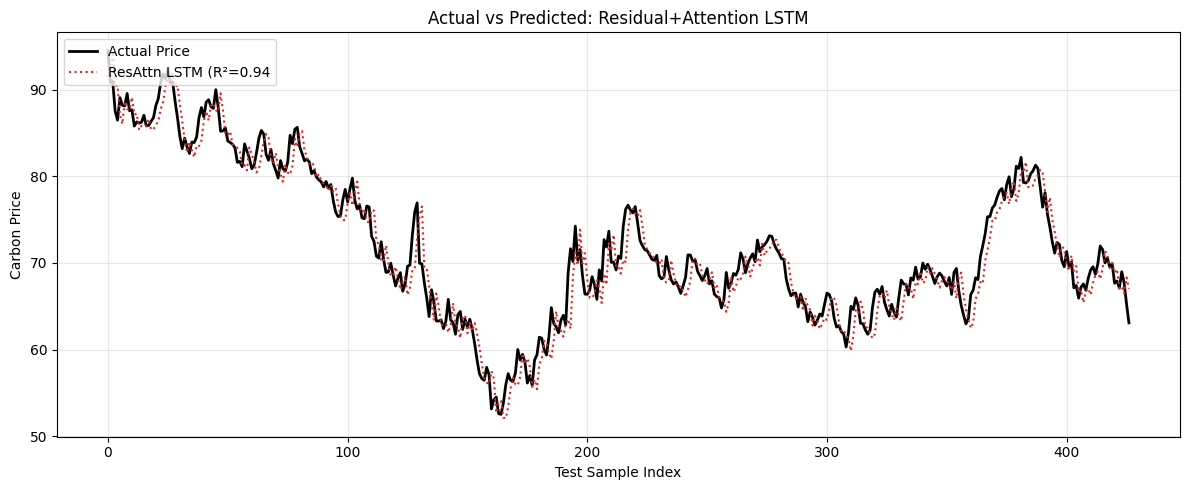

In [21]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def get_preds(model, df, feats, seq_len, device, scaler_y):
    loader = DataLoader(TSData(df, feats, seq_len), batch_size=32, pin_memory=True)
    model.to(device).eval()

    preds, true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb.to(device)).cpu().numpy()
            preds.extend(out)
            true.extend(yb.numpy())

    preds = scaler_y.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
    true  = scaler_y.inverse_transform(np.array(true).reshape(-1,1)).flatten()
    return np.array(true), np.array(preds)

if __name__ == "__main__":
    device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    path    = "/content/final_dataset_1.csv"
    lag_feats = [
      " Price Index for Consumer: Energy(electricity, heat, fuel) ",
      "Crude Oil Prices: Brent - Europe",
      "euro_stoxx"
    ]
    seq_len = 45

    df_tr, df_val, df_te, feats, sy = prepare_data(path, lag_feats)
    train_dl = DataLoader(TSData(df_tr, feats, seq_len), batch_size=32, shuffle=True)
    val_dl   = DataLoader(TSData(df_val, feats, seq_len), batch_size=32)

    attn_model = train_validate(ResidualAttentionLSTM(feats),   train_dl, val_dl, device)

    true_vals,  preds_attn = get_preds(attn_model, df_te, feats, seq_len, device, sy)

    r2_attn   = r2_score(true_vals, preds_attn)

    plt.figure(figsize=(12,5))
    plt.plot(true_vals,  color='black', label='Actual Price', linewidth=2)
    plt.plot(preds_attn, color='tab:red',
             label=f'ResAttn LSTM (R²={r2_attn:.2f}', linestyle=':')
    plt.xlabel("Test Sample Index")
    plt.ylabel("Carbon Price")
    plt.title("Actual vs Predicted: Residual+Attention LSTM")
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
